In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


Root Mean Square Error:  450.72663575504566


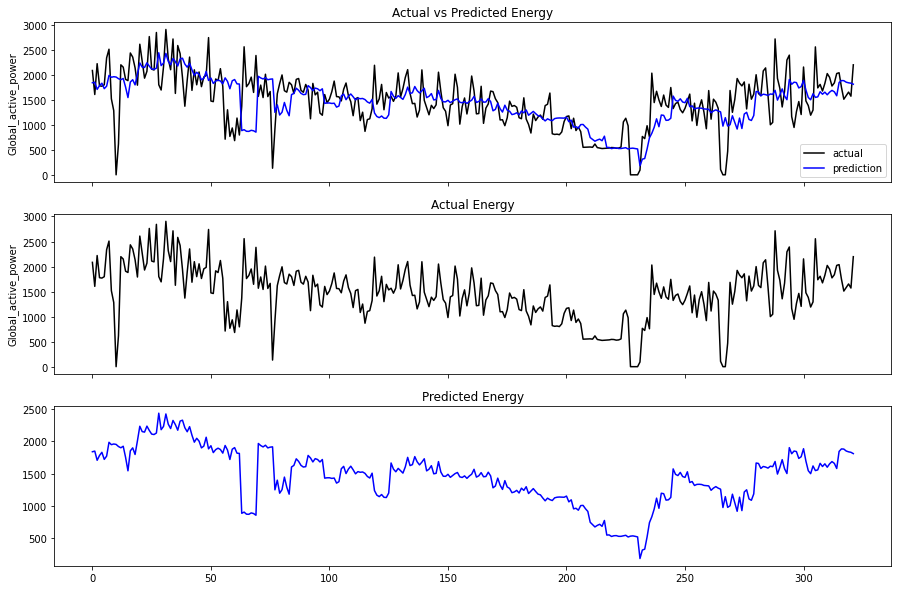

In [ ]:
#LSTM
from pandas import read_csv
import keras.models as models
import keras.layers as layers
from sklearn.metrics import mean_squared_error
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# load the new file
#dataset = pd.read_csv('/content/gdrive/My Drive/dataset2.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])
dataset = pd.read_csv('/content/gdrive/My Drive/dataset2.txt', sep=';', header=0, usecols = ["Date","Time","Global_active_power"], 
                       low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, 
                       index_col=['datetime'], na_values=["NaN","?"])
dataset.replace('?', np.nan, inplace=True)
dataset = dataset.astype('float32')

daily_groups = dataset.resample('D')#resampling to daily
monthly_groups = dataset.resample('M')#resampling to monthly
weekly_groups = dataset.resample('W')# resample data to weekly
daily_data = daily_groups.sum()
monthly_data = monthly_groups.sum()
weekly_data = weekly_groups.sum()

daily_data.to_csv('dataset2_daily.csv')
monthly_data.to_csv('dataset2_monthly.csv')
weekly_data.to_csv('dataset2_weekly.csv')

daily_dataset = read_csv('dataset2_daily.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
monthly_dataset = read_csv('dataset2_monthly.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
weekly_dataset = read_csv('dataset2_weekly.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])

daily_train, daily_test = daily_dataset[1:-328], daily_dataset[-328:-6]
daily_train = np.array(np.split(daily_train, len(daily_train)/7))
training = daily_train.reshape((daily_train.shape[0]*daily_train.shape[1], daily_train.shape[2]))
daily_test = np.array(np.split(daily_test, len(daily_test)/7))
monthly_train, monthly_test = monthly_dataset[:36], monthly_dataset[36:]
monthly_train = np.array(np.split(monthly_train, len(monthly_train)/3))
monthly_test = np.array(np.split(monthly_test, len(monthly_test)/3))
weekly_train, weekly_test = weekly_dataset[:153], weekly_dataset[153:]
weekly_train = np.array(np.split(weekly_train, len(weekly_train)/3)) 
weekly_test = np.array(np.split(weekly_test, len(weekly_test)/3))

x_train_daily, y_train_daily = list(), list()
predict = list()
initial_index = 0
mean_square_err = 0
d_test = daily_test[:, :, 0]

#Generating training and test data
old = [item for item in daily_train]
for index in range(len(training)):
  end_index = initial_index + 7#No of weeks to be used to train
  index_out = end_index + 7#No of weeks to be predicted
  if index_out < len(training):
    in_x = training[initial_index:end_index, 0]
    x_train_daily.append(in_x.reshape((len(in_x), 1)))
    y_train_daily.append(training[end_index:index_out, 0])
  initial_index+=1
x_train_daily = np.array(x_train_daily)
y_train_daily = np.array(y_train_daily)

#Defining a model
seq = models.Sequential()
seq.add(layers.LSTM(200, activation='relu', input_shape=(x_train_daily.shape[1], x_train_daily.shape[2])))
seq.add(layers.Dense(100, activation='relu'))
seq.add(layers.Dense(y_train_daily.shape[1]))
seq.compile(loss = 'mse', optimizer = 'adam')
seq.fit(x_train_daily, y_train_daily, epochs=50, batch_size=50, verbose=0)

#Testing the model
for i in range(0, len(daily_test)):
  old_data = np.array(old)
  old_data = old_data.reshape((old_data.shape[0]*old_data.shape[1], old_data.shape[2]))
  prev = old_data[-7:,0]
  prev = prev.reshape((1, len(prev), 1))
  pred_next_week = seq.predict(prev, verbose=0)
  pred_next_week = pred_next_week[0]
  predict.append(pred_next_week)
  old.append(daily_test[i,:])
predict = np.array(predict)

actual = list()
forecasted = list()
for i in range(0, len(d_test)):
  for j in range(0, len(d_test[i])):
    actual.append(d_test[i][j])
    forecasted.append(predict[i][j])

err_magnitude = mean_squared_error(d_test, predict, squared=False)
fig, axes = plt.subplots(3, figsize=(15, 10), sharex=True)

axes[1].plot(actual, color='black', label='actual')
axes[1].set_title('Actual Energy')
axes[1].set_ylabel('Global_active_power')

axes[2].plot(forecasted, color='blue', label='predict')
axes[2].set_title('Predicted Energy')

axes[0].set_title('Predicted Energy')
axes[0].set_ylabel('Global_active_power')
axes[0].plot(actual, color='black', label='actual')
axes[0].plot(forecasted, color='blue', label='prediction')
axes[0].set_title('Actual vs Predicted Energy')
axes[0].set_ylabel('Global_active_power')
axes[0].legend()
print("Root Mean Square Error: ",err_magnitude)

Root Mean Square Error for ARIMA:  0.15354534399795738


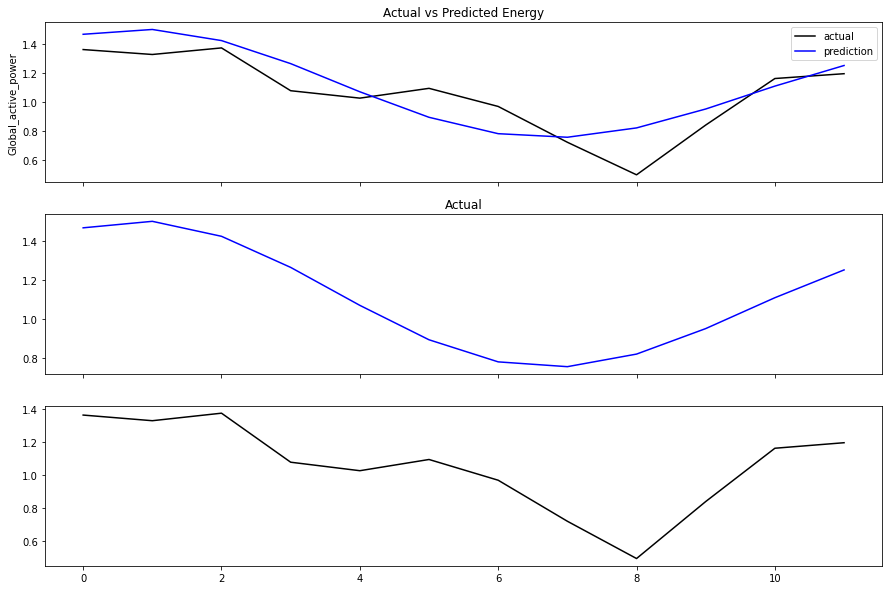

In [ ]:
#ARIMA Monthly
from pandas import read_csv
import keras.models as models
import keras.layers as layers
from sklearn.metrics import mean_squared_error
import math
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
import matplotlib.pyplot as plt
%matplotlib inline

actual_array = list()
predicted_array = list()

#Reading the data
data = pd.read_csv('/content/gdrive/My Drive/dataset2.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])
data.replace('?', np.nan, inplace=True)

#Data Preprocessing
data = data.astype('float32')
datas = data["Global_active_power"]
datas.replace(np.nan, 0, inplace=True)

#Fetching the monthly data
monthly=datas.resample('M').mean()
train = monthly[:36]
test = monthly[36:]

#Training the model
Arima_model=pm.auto_arima(train)

#Testing the model
predicted = pd.DataFrame(Arima_model.predict(n_periods=12))

#Calculating the RMSE
for i in range(0, len(test)):
  actual_array.append(test[i])
for i in range(0, len(predicted)):
  predicted_array.append(predicted[0][i])
err_magnitude = mean_squared_error(test, predicted, squared=False)
print("Root Mean Square Error for ARIMA: ",err_magnitude)
f, axes = plt.subplots(3, figsize=(15, 10), sharex=True)

#Plotting
axes[0].plot(actual_array, color='black', label='actual')
axes[0].plot(predicted_array, color='blue', label='prediction')
axes[0].set_title('Actual vs Predicted Energy')
axes[0].set_ylabel('Global_active_power')
axes[0].legend()

axes[1].plot(predicted_array, color='blue', label='prediction')
axes[1].set_title('Predicted')

axes[2].plot(actual_array, color='black', label='Actual')
axes[1].set_title('Actual')

plt.show()


Root Mean Square Error for SARIMA:  0.10906403125809291


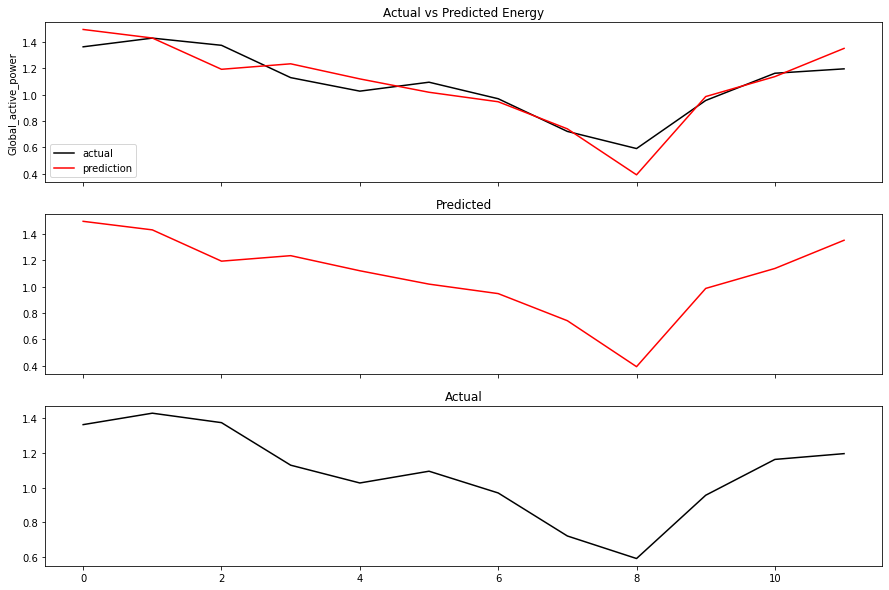

In [ ]:
##SARIMA Monthly
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
import pandas as pd
from pandas import read_csv
import numpy as np

actual_array = list()
predicted_array = list()
#Reading the data
dataset = read_csv('/content/gdrive/My Drive/dataset2.txt', sep=';', low_memory=False,header=0, usecols = ["Date","Time","Global_active_power"], 
                       infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])
dataset.replace('?', np.nan, inplace=True)

#Data Preprocessing
dataset = dataset.astype('float32')
monthly=dataset.resample('M').mean()
train = monthly[:36]
test = monthly[36:]

#Training the model
model = SARIMAX(train, order=(1, 1, 1),seasonal_order=(1, 1, 0, 12),enforce_stationarity=False,enforce_invertibility=False)
#Forecasting
results = model.fit()
prediction = results.predict(start='2009-12-31', end='2010-11-30')
prediction.columns = ['Date_Time','Global_active_power']

for i in range(0, len(test)):
  actual_array.append(test["Global_active_power"][i])
  predicted_array.append(prediction[i])

#Calculating the RMSE
err_magnitude = mean_squared_error(test, prediction, squared=False)
print("Root Mean Square Error for SARIMA: ",err_magnitude)

#Plotting the graph
f, diag = plt.subplots(3, figsize=(15, 10), sharex=True)
diag[0].plot(actual_array, color='black', label='actual')
diag[0].plot(predicted_array, color='red', label='prediction')
diag[1].plot(predicted_array, color='red', label='prediction')
diag[1].set_title('Predicted')
diag[2].plot(actual_array, color='black', label='Actual')
diag[2].set_title('Actual')
diag[0].set_title('Actual vs Predicted Energy')
diag[0].set_ylabel('Global_active_power')
diag[0].legend()
plt.show()

Root Mean Square Error for SARIMA:  0.30469998557026995


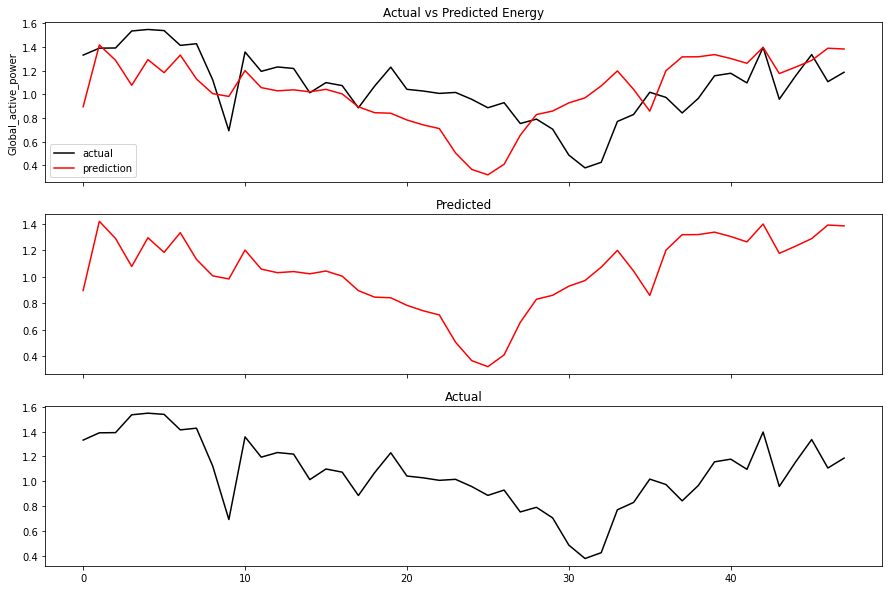

In [ ]:
##SARIMA Weekly
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error

actual_array = list()
predicted_array = list()

#Reading the data
dataset = pd.read_csv('/content/gdrive/My Drive/dataset2.txt', sep=';', low_memory=False,header=0, usecols = ["Date","Time","Global_active_power"], 
                       infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])
#Data Preprocessing
dataset.replace('?', np.nan, inplace=True)
dataset = dataset.astype('float32')
weekly=dataset.resample('W').mean()
train = weekly[0:159]
test = weekly[159:]

#Training the model
model = SARIMAX(train, order=(1, 1, 1),seasonal_order=(1, 1, 0, 48),enforce_stationarity=False,enforce_invertibility=False)
#Testing the mode
results = model.fit()
prediction = results.predict(start='2010-01-03', end='2010-11-28')
prediction.columns = ['Date_Time','Global_active_power']

for i in range(0, len(test)):
  actual_array.append(test["Global_active_power"][i])
  predicted_array.append(prediction[i])

err_magnitude = mean_squared_error(actual_array, predicted_array, squared=False)
print("Root Mean Square Error for SARIMA: ",err_magnitude)

#Plotting
f, diag = plt.subplots(3, figsize=(15, 10), sharex=True)
diag[0].plot(actual_array, color='black', label='actual')
diag[0].plot(predicted_array, color='red', label='prediction')
diag[1].plot(predicted_array, color='red', label='prediction')
diag[1].set_title('Predicted')
diag[2].plot(actual_array, color='black', label='Actual')
diag[2].set_title('Actual')
diag[0].set_title('Actual vs Predicted Energy')
diag[0].set_ylabel('Global_active_power')
diag[0].legend()
plt.show()